In [5]:
import os
os.chdir('/mnt/resource/Etc/PyCharm Projects/NewSubachan')

In [ ]:
%pwd

# main.py

In [9]:
import tokenizer
import normalizer
import g2p
import synthesizer


def main():
    #text = input('Input Text: ')

    f = open('input_text.txt', 'r')
    text = f.read()
    print('Input Text:\n', text)

    sentences = tokenizer.tokenize_sentence(text)

    # process the text sentence-wise
    for txt in sentences:
        tokens = tokenizer.tokenize_text(txt)
        total_tokens = len (tokens)
        # for token in tokens:
        #     print(token)

        # normalization here
        # normalizer.py is incomplete - till date
        norm = normalizer.Normalizer()

        normalized_tokens = [""]
        for i in range(1, total_tokens-1):
            norm_token = norm.normalize(tokens[i-1 : i+2])
            normalized_tokens.append(norm_token)
        normalized_tokens.append("")

        print('Normalized:', end=' ')
        print(''.join(normalized_tokens) + '\n')



        # g2p conversoin
        g2p.init_g2p()
        total_tokens = len (normalized_tokens)
        synthesizer.init_synthesizer()
        for i in range(1, total_tokens-1):
            # passing a list of 3 words in g2p.getUnits()
            # the word in the middle is to be processed.
            units = g2p.getUnits(normalized_tokens[i-1 : i+2])
            print(units)
            synthesizer.playUnits(units)


if __name__ == '__main__':
    main()

Input Text:
 আম্‌রা প্রত্‌তেকেই খুব্‌ শল্‌প শময়ের্‌ জন্‌ন বেচে থাকি, এবং এই শল্‌প শময়ের্‌ মাঝে এই শমগ্র মহাবিশ্‌শের্‌ অল্‌প অংশই আমাদের্‌ পক্‌খে দেখা বা অনুশন্‌ধান্‌ করা শম্‌ভব্‌ হয়ে ওঠে না। কিন্‌তু মানব্‌ প্রজাতি খুব্‌ই কোউ্‌তুহলি। আম্‌রা বিশ্‌শিত হই, আম্‌রা উত্‌তর্‌ খুজি। 


Normalized: আম্‌রা প্রত্‌তেকেই খুব্‌ শল্‌প শময়ের্‌ জন্‌ন বেচে থাকি, এবং এই শল্‌প শময়ের্‌ মাঝে এই শমগ্র মহাবিশ্‌শের্‌ অল্‌প অংশই আমাদের্‌ পক্‌খে দেখা বা অনুশন্‌ধান্‌ করা শম্‌ভব্‌ হয়ে ওঠে না। 

['আ', 'আম্', 'রা-']
[' ']
['প্র', 'অত্', 'তে', 'একে', 'এই-']
[' ']
['খু', 'উব্']
[' ']
['শ', 'অল্', 'প-']
[' ']
['শ', 'অম', 'অয়ে', 'এর্']
[' ']
['জ', 'অন্', 'ন-']
[' ']
['বে', 'এচে-']
[' ']
['থা', 'আকি}']
[',']
[' ']
['এ', 'এব', 'অং']
[' ']
['এ', 'এই-']
[' ']
['শ', 'অল্', 'প-']
[' ']
['শ', 'অম', 'অয়ে', 'এর্']
[' ']
['মা', 'আঝে-']
[' ']
['এ', 'এই-']
[' ']
['শ', 'অম', 'অগ্', 'র-']
[' ']
['ম', 'অহা', 'আবি', 'ইশ্', 'শে', 'এর্']
[' ']
['অ', 'অল্', 'প-']
[' ']
['অ', 'অং', 'অশ', 'অই-']
[' ']
['আ', 'আমা', 'আদে', 'এর্']
[' ']
['প', '

## Synthesizer

In [1]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
import peakutils
from IPython.display import Audio
import sounddevice as sd

In [20]:
ms10 = 441 # number of units in each 10 ms

units = ['শ', 'অম', 'অয়ে', 'এর্‌']

def playUnits(units):
    dirname = '/mnt/resource/Etc/PyCharm Projects/NewSubachan/New Units/'

    # normalization factor
    # we devide each sample by this factor
    # to normalize the signal between -1.0 to 1.0
    NORM_FACTOR = 23000

    output = np.zeros (1000000)

    pm1 = -1
    pm2 = -1
    prev = -1
    index = 0


    for unit in units:
        if unit in [' ', ',', ';', '।']:
            if unit == ' ':
                # print('stop for space')
                index += ms10 * 5   # 40ms of silence between words
            elif unit in [',', ';']:
                # print('stop for comma semi-colon')
                index += ms10 * 20  # 200 ms os silence for [, ;]
            else:
                # print('stop for full stop')
                index += ms10 * 50  # 500 ms of silence for daRi ('।')
            break

        if unit.endswith (chr (0x9cd)):
            filename = dirname + unit + "\u200C" + '.wav'
        # turn it on only if duration modeling is used.
        # elif unit.endswith('-'):
        #     unit2 = unit[:-1] + '}'
        #     filename = dirname + unit2 + '.wav'
        else:
            filename = dirname + unit + '.wav'

        try:
            fs, w = wavfile.read (filename)
        except FileNotFoundError:
            if unit.endswith('-'):
                unit2 = unit[:-1] + '}'
                filename = dirname + unit2 + '.wav'
                try:
                    fs, w = wavfile.read(filename)
                except FileNotFoundError:
                    print (filename + ' not found.')
                    prev = -1  # no overlap for next unit
                    continue
            else:
                print (filename + ' not found.')
                prev = -1  # no overlap for next unit
                continue

        wlen = len (w)
        if wlen == 0: continue
        # print('wlen:', wlen)

        # normalizing w
        # -------------

        # option 1: normalizing by max. value
        print('Normalization factor:', np.max(np.abs(w)))
        w = w / np.max(np.abs(w))
        
        # option 2: normalizing by a common factor
        # print('max value: ', np.max(np.abs(w)))
#         w = w / NORM_FACTOR

        # detecting peaks with peakutils.indexes()
        idx = peakutils.indexes (w, thres=0.2, min_dist=100)
        # print('total peaks: ', len(idx))

        #################
        # Overlap & Add #
        #################
        if len (idx) < 2:
            print ('less than 2 peaks for ', unit)
            exit (1)

        pm1 = idx[0]
        pm2 = idx[-1]

        if prev == -1:  # starting of a word/syllable
            output[index: index + wlen] = w
            prev = index + pm2
            index += wlen
            continue

        i = prev - pm1
        j = 0
        print('index:', index, ' prev:', prev, ' pm1:', pm1, ' pm2:', pm2)
        print(unit, 'ratio:', w[pm1]/w[pm2])
        while i < index and j < wlen:
            output[i] = (output[i] + w[j]) / 2.0
            i += 1
            j += 1

        while j < wlen:
            output[index] = w[j]
            if j == pm2: prev = index
            index += 1
            j += 1

        # a hoshont is encountered, so no overlap-add for the next unit
        if unit.endswith (chr (0x9cd)):
            prev = -1


    output = output[:index].copy ()
    # print ('samples:', len (output))
#     sd.play (output, samplerate=44100, blocking=True)
    audio = Audio(output, rate=44100, autoplay=False)
    return audio
    
ad = playUnits(units)
ad

Normalization factor: 9924
Normalization factor: 17233
index: 10089  prev: 9985  pm1: 14  pm2: 11874
অম ratio: 8.502595155709344
Normalization factor: 14899
index: 21879  prev: 21845  pm1: 19  pm2: 10591
অয়ে ratio: 2.8345833333333332
Normalization factor: 9661
index: 32485  prev: 32417  pm1: 34  pm2: 8009
এর্‌ ratio: 40.433734939759034


## Plotting waves with peaks

In [11]:
%matplotlib inline

In [2]:
dirname = '/mnt/resource/Etc/PyCharm Projects/NewSubachan/New Units/'

filename = dirname + 'আবি.wav'

fs, w = wavfile.read(filename)

# normalization
w = w / 24000

/home/arif/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  This is separate from the ipykernel package so we can avoid doing imports until


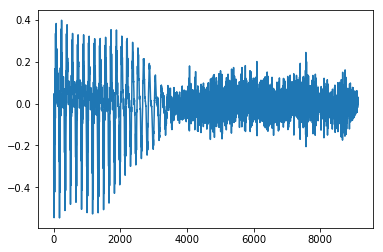

In [26]:
plt.figure(1)
plt.plot(w)
plt.hold()

In [6]:
# detecting peaks with peakutils.indexes()
idx = peakutils.indexes (w, thres=0.5, min_dist=150)
print('Total peaks:', len(idx))

peaks = np.zeros(len(w))
prev = 0
for i in idx:
    peaks[i] = w[i]
    print(i, '\t', i-prev, '\t', w[i])
    prev = i

Total peaks: 54
93 	 93 	 0.7182083333333333
291 	 198 	 0.747625
489 	 198 	 0.7405416666666667
688 	 199 	 0.7257083333333333
885 	 197 	 0.7065416666666666
1083 	 198 	 0.6677083333333333
1280 	 197 	 0.641625
1478 	 198 	 0.6111666666666666
1675 	 197 	 0.592125
1873 	 198 	 0.5724166666666667
2072 	 199 	 0.504125
2270 	 198 	 0.3898333333333333
2468 	 198 	 0.34841666666666665
2669 	 201 	 0.3360416666666667
2872 	 203 	 0.082625
3031 	 159 	 0.051666666666666666
3232 	 201 	 0.06091666666666667
3424 	 192 	 0.08579166666666667
3646 	 222 	 0.07595833333333334
3875 	 229 	 0.072125
4088 	 213 	 0.069625
4310 	 222 	 0.05579166666666667
4540 	 230 	 0.06341666666666666
4766 	 226 	 0.061
4994 	 228 	 0.051541666666666666
5222 	 228 	 0.0415
5454 	 232 	 0.04625
5683 	 229 	 0.043625
5903 	 220 	 0.04595833333333333
6121 	 218 	 0.04504166666666667
6312 	 191 	 0.09291666666666666
6480 	 168 	 0.1545
6685 	 205 	 0.14766666666666667
6868 	 183 	 0.12741666666666668
7072 	 204 	 0.1

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


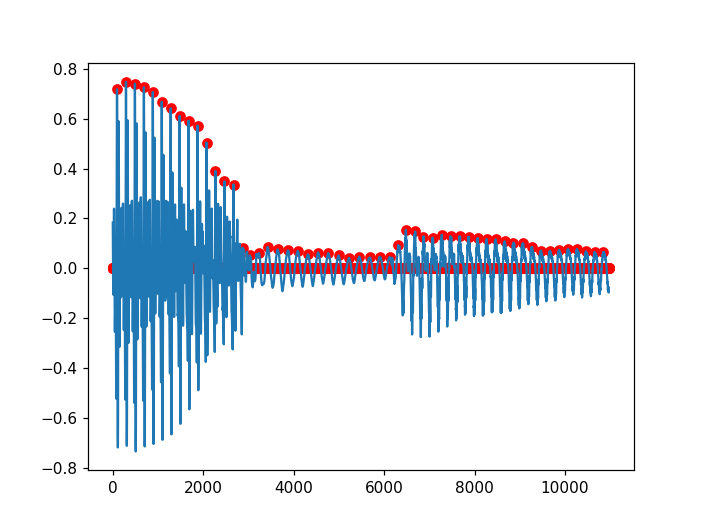

In [7]:
#plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(range(len(w)), peaks, 'ro')
plt.plot(w)